# Bayesian Multi-Armed Bandit for Customer Segment Discovery and Shipping Price Optimization

We propose a Multi-Armed Bandit to optimize the use of the shipping discounts budget. This solution allows a dynamic targeting of customer segments.  

We run campaigns and A/B tests in which we subsidize shipping price. These interventions are usually not targeted to a particular customer segment or category.  Both high-performing and low-performing customer segments share a budget, an intervention, and a time-frame in which it is applied. The sample sizes for the 'A' and 'B' test groups are decided before the test begins, and the test run for a fixed amount of time.   

A Multi-Armed Bandit (MAB) is an "online learning" strategy.  It allows us to discover the best customer segments. This is done while the shipping discount campaign is running. MAB allocates budget to the customer segments that maximize reward. MAB automates the discovery of promising segments and the allocation of resources. MAB allows us to execute a 'continuous' shipping discount campaign. Only the restriction total number of users that convert and use the discount is present.

We have a suite of potential customer/item segments. We also have a suite of shipping campaign delivery strategies. These strategies could be email, popups, or private messages.  We are not sure which combinations of these strategies and segments bring uplift. A Multi-armed bandit is like 'dynamic' A/B testing, with the advantage of maximizing the strategies with most uplift.   

### Hypothesis

* A MAB allows us to maximize the number of new users that convert while we run a shipping discounts campaign. It finds the optimal strategy at which to promote the campaign. This works at any time interval for the customer or item segments that we want to uplift.

### Customer behavior that we want to impact

Number of first time users (buyers or sellers).

### What is a Multi-Armed Bandit?

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Las_Vegas_slot_machines.jpg/1024px-Las_Vegas_slot_machines.jpg)

> Multi-armed bandit problem is a problem in which a gambler at a row of slot machines (sometimes known as “one-armed bandits”) **has to decide which machines to play, how many times to play each machine and in which order to play them**. When played, each machine provides a random reward from a probability distribution specific to that machine. **The objective of the gambler is to maximize the sum of rewards earned through a sequence of lever pulls.**

> The multi-armed bandit problem models an agent that simultaneously attempts to acquire new knowledge (called "exploration") and optimize their decisions based on existing knowledge (called "exploitation"). The agent attempts to balance these competing tasks in order to maximize their total value over the period of time considered.

From Wikipedia https://en.wikipedia.org/wiki/Multi-armed_bandit




## A brief description of the Bayesian Multi-armed bandit algorithm

In our model each customer segment is a 'bandit'. Our task is to identify which of these maximizes reward (e.g. conversion to first time sellers / buyers).

A MAB is an iterative algorithm that works in rounds. Each round  updates our estimates of behavior for the different customer segments.

For each round:

1. Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
2. Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
3. Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
4. Return to 1.

The algorithm involves sampling and updating $N$ distributions. We have as many distributions as segments of sellers or buyers. The distribution with which we start sampling is called the initial prior.
A posterior probability is the updated probability of success after considering new data. The posterior probability is calculated by updating the prior probability using Bayes' theorem.

We start the algorithm using a uniform distribution for a bandit's reward. This initial uniform distribution is a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with parameters $\alpha = \beta = 1.0 $. These parameters are what we will update with our wins and losses.  

$$\text{Initial priors} = \text{Beta}(\alpha=1,\beta=1)$$

The observed result of $X$ is a win (1) or a loss (0). We represent this with a binomial distribution. This binomial distribution tweaks the alpha and beta parameters. This is how we learn from experience.   

The posterior probability distribution for each bandit is then
 $$\text{Beta}(\alpha=1+X,\beta=1+N−X)$$

 With $N$ being number of trials and $X$ being number of successes.

This new posterior probability becomes the prior for the next round.

For example, a given bandit (customer segment) starts with $\text{Beta}(1, 1)$ and prior on $p$.

We then observe conversion data $X \sim \text{Binomial}(N, p)$ for the customer segment.

Every new customer that receives the discount is a trial $N$. A new customer that converts is a success $X$. The posterior probability updates as $\text{Beta}(1 + X, 1 + N -X)$.  If we observe that $X = 10$ new conversions, out of $N=25$ trials, then our posterior for $p$ is $\text{Beta}(1+10, 1+25-10) = \text{Beta(11, 16)}$.

We keep this tally of successes and trials for the next update of the bandit in the paramaters. In the next round we do $N = 100$ trials and get $X=50$,
we then update $\text{Beta}(11+50, 16+100-50) = \text{Beta}(50, 66)$.  







In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

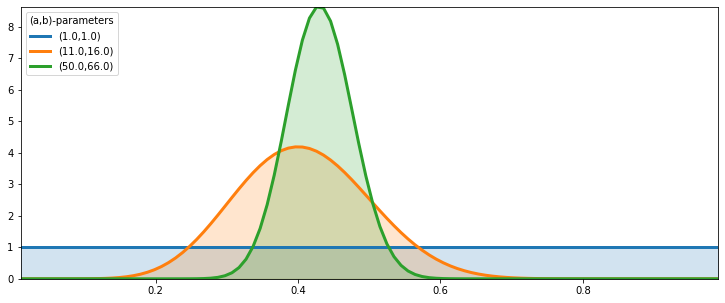

In [ ]:
#@title Updating the beta distribution with evidence
#@markdown The blue distribution is our initial prior
#@markdown, orange represents our first update
#@markdown, green is the next update.
figsize(12.5, 5)
beta = stats.beta

parameters = [(1., 1.), (11., 16.), (50, 66)]
x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in parameters:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label = "(%.1f,%.1f)"%(a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha = 0.2, color = lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc = 'upper left', title="(a,b)-parameters");

The MAB algorithm does not discard poorly performing customer or product segments. It picks them at a decreasing rate as we gather confidence that there exist better segments. This represents a non-zero chance that a poorly performing segment may improve. Its improvement will depend on the evidence of success.

## Vinted Implementation

To implement MAB we will first need to identify candidate customer segments. We also need to define the appropriate time interval used to update priors.

As this is an online learning strategy, a Kafka implementation ([like this one](https://github.com/dre-hh/kafka_bandits)) will be necessary.

To maximize conversion a notification of the dynamically-allocated shipping discount might require frontend updates or automated messaging to users.  

In [ ]:
!pip install pymc

In [ ]:
from pymc import rbeta
import numpy as np

In [ ]:
class Bandits(object):

  """
  This class represents N bandits
  (N different customer segments with different rewards,
  e.g. different conversion rates )

  parameters:

  p_array: an N-dimensional array of success probabilities
  (one for each bandit, each should be between 0 and 1)

  methods:

  pull(i): return the results, 0 or 1, of pulling the ith bandit

  """

  def __init__(self, p_array):
    self.p = p_array
    self.optimal = np.argmax(p_array)

  def pull(self, i):
    # i is the arm to pull,
    # i.e. the customer segment to which we have chosen to give a shipping discount
    return np.random.rand() < self.p[i]

  def __len__(self):
    return len(self.p)


class BayesianStrategy(object):
  """
  Implements an online, learning strategy to solve the
  Multi-Armed Bandit problem

  parameters:
    bandits: a bandit class with a .pull method


  methods:
    sample_bandits(n): sample and train on n pulls

  attributes
    N: cumulative number of samples
    choices: the historical choices as a (N,) array
    bb_score: the historical score as a (N,) array

  """


  def __init__(self, bandits):
    self.bandits = bandits
    n_bandits = len(self.bandits)
    self.wins = np.zeros(n_bandits)
    self.trials = np.zeros(n_bandits)
    self.N = 0
    self.choices = []
    self.bb_score = []

  def sample_bandits(self, n=1):
    # history of scores and choices
    # in our implementation this would be the history
    # of conversions in a given timeframe for a particular
    # customer or item segment
    bb_score = np.zeros(n)
    choices = np.zeros(n)

    for k in range(n):
      # sample from the bandits's priors and select the largest sample
      # the bandit with max number of wins will be the largest sample
      choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))

      # sample the winning bandit
      # for our implementation 'pull' would refer to offering discounts
      # to a customer segment
      result = self.bandits.pull(choice)

      # update priors and score
      self.wins[choice] += result
      self.trials[choice] += 1
      bb_score[k] = result
      self.N += 1
      choices[k] = choice

    self.bb_score = np.r_[self.bb_score, bb_score]
    self.choices  = np.r_[self.choices, choices]
    return

In [ ]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

figsize(13.0, 11)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha,
                         label="conversion probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

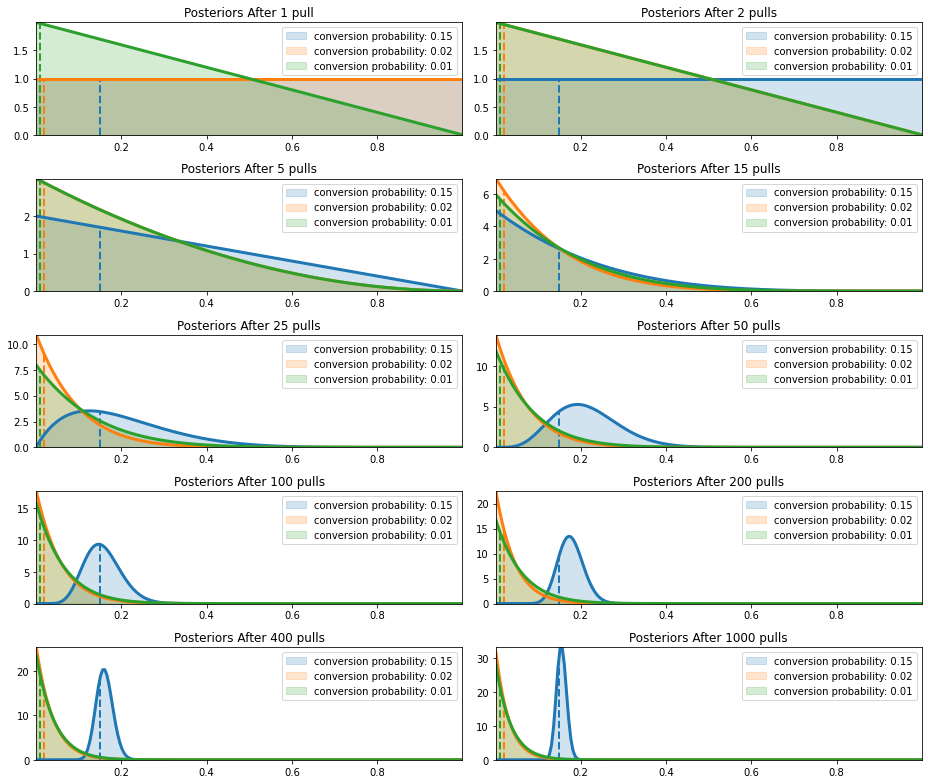

In [ ]:
# these 'hidden probabilities' are our success probabilities
# e.g. (percentage of new users that convert into first time buyers)
conversion_prob = np.array([0.15, 0.02, 0.01])
bandits = Bandits(conversion_prob)
bayesian_strat = BayesianStrategy(bandits)

# these work cumulatively, the last sample corresponds
# to a 1000 time intervals of experimentation
draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, conversion_prob)
    plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

## References

Code taken from chapter 6 of [Bayesian Methods for Hackers](https://www.amazon.de/-/en/Cameron-Davidson-Pilon/dp/0133902838) by Cameron Davidson (former Head of Data Science at [Shopify](https://www.shopify.com/))

* https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter6_Priorities

Full chapter available as an interactive notebook in nbviewer.org

* https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC2.ipynb

* Text of the chapter also available in the author's blog https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits

* Intro to multi-armed bandits, book by MS Research https://arxiv.org/pdf/1904.07272.pdf

* Microsoft's Custom Decision Project https://www.microsoft.com/en-us/research/project/custom-decision/

* https://www.microsoft.com/en-us/research/publication/multiworld-testing-decision-service/

* https://towardsdatascience.com/contextual-bandits-and-reinforcement-learning-6bdfeaece72a

* https://medium.com/complex-engine/how-we-used-microsofts-decision-service-to-significantly-boost-conversion-rates-a72c76b983e9

* https://github.com/microsoft/mwt-ds

* Personalizer seems to be the current implementation contextual bandits by Microsoft https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/concepts-reinforcement-learning

* https://www.techrepublic.com/article/microsofts-cutting-edge-machine-learning-tool-moves-from-the-lab-to-the-mainstream/


* https://github.com/dre-hh/kafka_bandits

* https://www.confluent.io/events/kafka-summit-americas-2021/building-adaptive-user-experiences-using-contextual-multi-armed-bandits-with/

* https://www.youtube.com/watch?v=bkw6hWvh_3k

* https://www.youtube.com/watch?v=EI-Idn2Soi0

* https://vwo.com/blog/multi-armed-bandit-algorithm/

* https://www.youtube.com/watch?v=XxTgX8FlDlI

* Improving multi-armed bandtis for online pricing https://www.sciencedirect.com/science/article/abs/pii/S0888613X17303821

* Price optimization with multi-armed bandits w.r.t. buyer demand (markeplace scenario https://ewrl.files.wordpress.com/2015/02/ewrl12_2015_submission_23.pdf)

* https://www.kaggle.com/ruslankl/how-to-deal-with-multi-armed-bandit-problem

* Bandits Book https://tor-lattimore.com/downloads/book/book.pdf